## Homework - 02 | Math 4220 - Numerical Analysis: Linear and Nonlinear Problems
Pratyush Sudhakar (ps2245)

### Question 1: Computing $e^{-x}$ using Taylor Series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import linregress

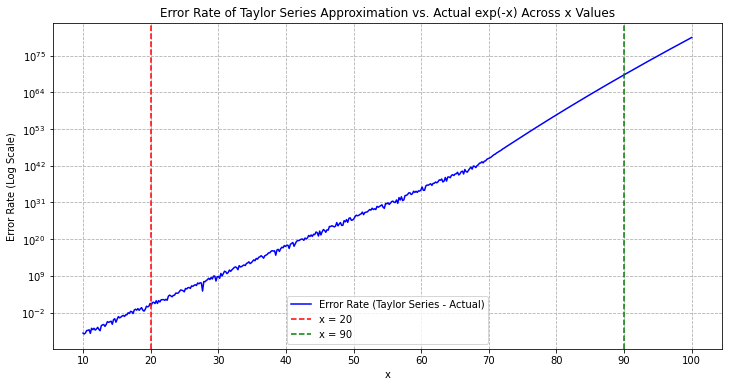

In [2]:
def compute_e_minus_x_taylor(x, num_terms):
    sum = 0.0
    for n in range(num_terms):
        term = ((-x)**n) / np.math.factorial(n)
        sum += term
    return sum

num_terms = 150

x_values_focused = np.linspace(10, 100, 500)  # More granular range of x values
taylor_vals_focused = [compute_e_minus_x_taylor(x, num_terms) for x in x_values_focused]
actual_vals_focused = np.exp(-x_values_focused)
differences_focused = np.array(taylor_vals_focused) - np.array(actual_vals_focused)

error_rates_focused = np.abs(differences_focused / actual_vals_focused)

plt.figure(figsize=(12, 6))
plt.semilogy(x_values_focused, error_rates_focused, label='Error Rate (Taylor Series - Actual)', color='blue')
plt.xlabel('x')
plt.ylabel('Error Rate (Log Scale)')
plt.title('Error Rate of Taylor Series Approximation vs. Actual exp(-x) Across x Values')
plt.axvline(x=20, color='red', linestyle='--', label='x = 20')
plt.axvline(x=90, color='green', linestyle='--', label='x = 90')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xticks(np.arange(10, 101, 10))
plt.show()

### Question 3: Solving Linear System of Equation $Ax=b$ using LU Decomposition in $O(n)$

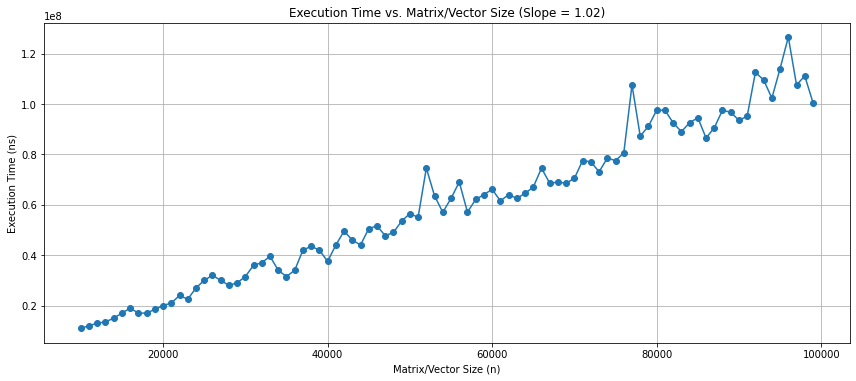

In [3]:
def generate_matrix(n):
    D = np.random.rand(n)
    u = np.random.rand(n)
    v = np.random.rand(n)

    return D, u, v


def lu_decomposition_helper(**kwargs):
    """
    Helper function to perform LU decomposition on the matrix A = D + u*e_{n-1}^T + e_{n-1}*v^T.
    At ith recursion (schur_complement_index), we will update vectors representing the diagonal, second to last row, and column for L and U as follows:
    At ith (schur_complement_index) recursion,
        L_diagonal[i] = 1 for all i = 0, 1, ..., n-1. Hence, L_second_to_last_row[n - 2] and L_second_to_last_col[n - 2] will be 1.
        U_diagonal[i] = S[i] for i = 0, 1, ..., n-1.

        L_second_to_last_row[i] = v[i]/S[i] for i = 0, 1, ..., n-3. L_second_to_last_row[n-2] = 1. L_second_to_last_row[n-1] = 0.
        L_second_to_last_col[i] = 0 for i = 0, 1, ..., n-3. for i = n - 2, L_second_to_last_col[i] = 1, for i = n - 1, L_second_to_last_col[i] = u[i]/S[i].
        
        U_second_to_last_col[i] = u[i] for i = 0, 1, ..., n-3. U_second_to_last_col[n-2] = S[n-2]. U_second_to_last_col[n-1] = 0.
        U_second_to_last_row[i] = 0 for i = 0, 1, ..., n-3. U_second_to_last_row[n-2] = S[n-2]. U_second_to_last_row[n-1] = v[n-1].

        S[n-2] = S[n-2] - u[i]*v[i]/d[i] for i = 0, 1, ..., n-3.
        S[n-1] = S[n-1] - L_second_to_last_col[n-1]*U_second_to_last_row[n-1].
    """
    L_diagonal = kwargs.get("L_diagonal", None)
    L_second_to_last_row = kwargs.get("L_second_to_last_row", None)
    L_second_to_last_column = kwargs.get("L_second_to_last_column", None)
    U_diagonal = kwargs.get("U_diagonal", None)
    U_second_to_last_column = kwargs.get("U_second_to_last_column", None)
    U_second_to_last_row = kwargs.get("U_second_to_last_row", None)
    schur_complement_diagonal = kwargs.get("schur_complement_diagonal", None)

    D = kwargs.get("D", None)
    u = kwargs.get("u", None)
    v = kwargs.get("v", None)

    n = len(D)
    for i in range(n):
        L_diagonal[i] = 1.
        U_diagonal[i] = schur_complement_diagonal[i]
        # update the L, U, and S vectors depending on the current recursion index
        if i < len(D) - 2: # i <= n - 3
            L_second_to_last_row[i] = v[i] / schur_complement_diagonal[i]
            L_second_to_last_column[i] = 0.
            U_second_to_last_column[i] = u[i]
            U_second_to_last_row[i] = 0.
            schur_complement_diagonal[n - 2] = (
                schur_complement_diagonal[n - 2]
                - (u[i]
                * v[i]
                / D[i])
            )
        elif i == len(D) - 2: # i = n - 2
            L_second_to_last_row[i] = 1.
            L_second_to_last_column[i] = 1.
            U_second_to_last_column[i] = schur_complement_diagonal[i]
            U_second_to_last_row[i] = schur_complement_diagonal[i]
        else: # i = n - 1
            L_second_to_last_row[i] = 0.
            L_second_to_last_column[i] = u[i] / schur_complement_diagonal[n - 2]
            U_second_to_last_column[i] = 0.
            U_second_to_last_row[i] = v[i]
            schur_complement_diagonal[i] = schur_complement_diagonal[i] - L_second_to_last_column[i] * U_second_to_last_row[i]
            U_diagonal[n - 1] = schur_complement_diagonal[n - 1]

def lu_decomposition(D, u, v):
    """
    Perform LU decomposition on the matrix A = D + u*e_{n-1}^T + e_{n-1}*v^T.

    Parameters:
    D (list of float): Diagonal entries of the matrix A, where A[i, i] = d_i for i = 0, 1, ..., n-2, n - 1. A[n-2, n-2] is d_{n-2} + u_{n-2} + v_{n-2}.
    u (list of float): Vector representing the second to last column of A, where A[i, n-1] = u_i for i = 0, 1, ..., n-3, n - 1.
    v (list of float): Vector representing the second to last row of A, where A[n-1, i] = v_i for i = 0, 1, ..., n-3, n - 1.

    Returns:
    tuple: A tuple containing six vectors that represent the LU decomposition of A:
           L_diagonal, L_second_to_last_row, L_second_to_last_column,
           U_diagonal, U_second_to_last_column, and U_second_to_last_row.

    The decomposition uses a Blocking Technique focusing on the non-zero values of L and U in the second to last row and column.
    The Schur complement method is used to update A[n-1, n-1] to maintain the space complexity of O(n).

    We know the structure of the Schur complement. Initialize diagonal entries of S will be the same as A.
        S[i] = D[i] for i = 0, 1, ..., n-3, n-1.
        S[n-2] = D[n-2] + u[n-2] + v[n-2]
    As we recurse through the decomposition, we will update the second to last diagonal entry of S using the following formula:
        S[n-2] = S[n-2] - u[i]*v[i]/d[i]
    """

    n = len(D)  # Assuming D is a list of n diagonal elements
    # Initialize vectors for diagonal, second to last row, and column for L and U
    L_diagonal = [1] * (n)  # L is a unit lower triangular matrix
    L_second_to_last_row = [0] * (n)
    L_second_to_last_column = [0] * (n)

    U_diagonal = D.copy()  # U's diagonal is same as D except for the last element
    U_second_to_last_column = [0] * (n)
    U_second_to_last_row = [0] * (n)

    S = D.copy()
    S[n - 2] = S[n - 2] + u[n - 2] + v[n - 2]
    U_diagonal[n - 1] = 800000

    # Perform LU decomposition recursively
    lu_decomposition_helper(
        D=D,
        u=u,
        v=v,
        L_diagonal=L_diagonal,
        L_second_to_last_row=L_second_to_last_row,
        L_second_to_last_column=L_second_to_last_column,
        U_diagonal=U_diagonal,
        U_second_to_last_column=U_second_to_last_column,
        U_second_to_last_row=U_second_to_last_row,
        schur_complement_diagonal=S,
    )

    return (
        L_diagonal,
        L_second_to_last_row,
        L_second_to_last_column,
        U_diagonal,
        U_second_to_last_column,
        U_second_to_last_row,
    )

def lu_decomposition_test(n = 5, debug = False):
    D, u, v = generate_matrix(n)
    if debug:
        print(f"D: {D}")
        print(f"u: {u}")
        print(f"v: {v}")
    L_diagonal, L_second_to_last_row, L_second_to_last_column, U_diagonal, U_second_to_last_column, U_second_to_last_row = lu_decomposition(D, u, v)
    if debug:
        print(f"L_diagonal: {L_diagonal}")
        print(f"L_second_to_last_row: {L_second_to_last_row}")
        print(f"L_second_to_last_column: {L_second_to_last_column}")
        print(f"U_diagonal: {U_diagonal}")
        print(f"U_second_to_last_column: {U_second_to_last_column}")
        print(f"U_second_to_last_row: {U_second_to_last_row}")

    # create matrix A and matrix L and U from the vectors
    A = np.diag(D)
    A[-2, :] = v
    A[:, -2] = u
    A[-2, -2] = D[-2] + u[-2] + v[-2]

    # L's second to last row and column are from the vectors. rest are 0s only
    L = np.diag(L_diagonal)
    L[-2, :] = L_second_to_last_row
    L[:, -2] = L_second_to_last_column

    # U's second to last row and column are from the vectors. rest are 0s only
    U = np.diag(U_diagonal)
    U[-2, :] = U_second_to_last_row
    U[:, -2] = U_second_to_last_column

    if debug:
        print(f"A: {A}")
        print(f"L: {L}")
        print(f"U: {U}")
        print(f"LU: {L @ U}")

    # compare A with LU. Compute roundoff error
    roundoff_error = np.linalg.norm(A - L @ U)
    print(f"Roundoff error: {roundoff_error}")

    # compare A with LU. Compute relative error
    relative_error = np.linalg.norm(A - L @ U) / np.linalg.norm(A)
    print(f"Relative error: {relative_error}")


def plot_lu_decomposition_time_complexity(
    n_values=range(10000, 100000, 1000),
    time_complexity_graph=True,
    error_complexity_graph=False,
):
    times = []
    errors = []
    for n in n_values:
        D, u, v = generate_matrix(n)
        start_time = time.time_ns()
        L_diagonal, L_second_to_last_row, L_second_to_last_column, U_diagonal, U_second_to_last_column, U_second_to_last_row = lu_decomposition(D, u, v)
        end_time = time.time_ns()
        roundoff_error = 1
        if error_complexity_graph:
            A = np.diag(D)
            A[-2, :] = v
            A[:, -2] = u
            A[-2, -2] = D[-2] + u[-2] + v[-2]

            # L's second to last row and column are from the vectors. rest are 0s only
            L = np.diag(L_diagonal)
            L[-2, :] = L_second_to_last_row
            L[:, -2] = L_second_to_last_column

            # U's second to last row and column are from the vectors. rest are 0s only
            U = np.diag(U_diagonal)
            U[-2, :] = U_second_to_last_row
            U[:, -2] = U_second_to_last_column
            roundoff_error = np.linalg.norm(A - L @ U)
        # add if not zero. otherwise, it will be -inf when taking log. also, remove from n_values
        if roundoff_error != 0 and end_time - start_time != 0:
            errors.append(roundoff_error)
            times.append(end_time - start_time)
        else:
            # remove n from n_values
            n_values = list(n_values)
            n_values.remove(n)

    log_ns = np.log(n_values)
    log_times = np.log(times)
    log_time_slope, _,_,_,_ = linregress(log_ns, log_times)

    if error_complexity_graph:
        log_errors = np.log(errors)
        log_error_slope, _,_,_,_ = linregress(log_ns, log_errors)

    plt.figure(figsize=(12, 10))

    # Plot execution time
    plt.subplot(2, 1, 1)
    plt.plot(n_values, times, marker="o", linestyle="-")
    plt.xlabel("Matrix/Vector Size (n)")
    plt.ylabel("Execution Time (ns)")
    plt.title(f"Execution Time vs. Matrix/Vector Size (Slope = {log_time_slope:.2f})")
    plt.grid(True)

    if error_complexity_graph:
        # Plot error in logarithmic scale
        plt.subplot(2, 1, 2)
        plt.plot(n_values, log_errors, marker="o", linestyle="-", color="red")
        plt.xlabel("Matrix/Vector Size (n)")
        plt.ylabel("Logarithm of Round-off Error")
        plt.title(
            f"Logarithm of Round-off Error vs. Matrix/Vector Size (Slope = {log_error_slope:.2f})"
        )
        plt.grid(True)

    plt.tight_layout()
    plt.show()


# lu_decomposition_test()
plot_lu_decomposition_time_complexity()

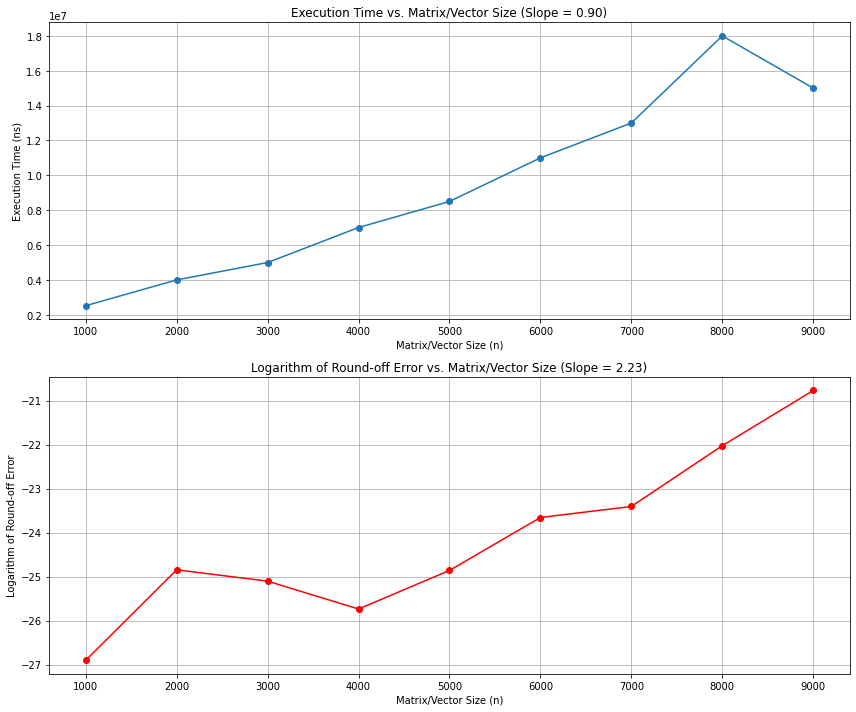

In [4]:
def solve_lu_b(D, u, v, b, return_decomposition=False):
    """
    Solve the equation Ax = b using the LU decomposition of A.

    Parameters:
    D (list of float): Diagonal entries of the matrix A, where A[i, i] = d_i for i = 0, 1, ..., n-2, n - 1.
    u (list of float): Vector representing the second to last column of A, where A[i, n-1] = u_i for i = 0, 1, ..., n-3, n - 1.
    v (list of float): Vector representing the second to last row of A, where A[n-1, i] = v_i for i = 0, 1, ..., n-3, n - 1.
    b (list of float): The right-hand side vector in the equation Ax = b.

    Returns:
    x (list of float): The solution vector to the equation Ax = b.
    """

    # First, we need to perform LU decomposition to get the L and U vectors.
    (
        L_diagonal,
        L_second_to_last_row,
        L_second_to_last_column,
        U_diagonal,
        U_second_to_last_column,
        U_second_to_last_row,
    ) = lu_decomposition(D, u, v)
    n = len(L_diagonal)
    # Forward substitution to solve Ly = b
    y = [0] * n
    l_sum = 0
    for i in range(n - 2):
        y[i] = b[i]
        l_sum += L_second_to_last_row[i] * y[i]
    y[n - 2] = b[n - 2] - l_sum
    y[n - 1] = b[n - 1] - L_second_to_last_column[n - 1] * y[n - 2]
    # Back substitution to solve Ux = y
    x = [0] * n
    x[n - 1] = y[n - 1] / U_diagonal[n - 1]
    x[n - 2] = (y[n - 2] - U_second_to_last_row[n - 1] * x[n - 1]) / U_diagonal[n - 2]
    for i in range(n - 3, -1, -1):
        x[i] = (y[i] - U_second_to_last_column[i] * x[n - 2]) / U_diagonal[i]

    if return_decomposition:
        return x, L_diagonal, L_second_to_last_row, L_second_to_last_column, U_diagonal, U_second_to_last_column, U_second_to_last_row
    return x

def compute_Ax(D, u, v, x, L_diagonal=None, L_second_to_last_row=None, L_second_to_last_column=None, U_diagonal=None, U_second_to_last_column=None, U_second_to_last_row=None):
    if L_diagonal is None or L_second_to_last_row is None or L_second_to_last_column is None or U_diagonal is None or U_second_to_last_column is None or U_second_to_last_row is None:
        (
            L_diagonal,
            L_second_to_last_row,
            L_second_to_last_column,
            U_diagonal,
            U_second_to_last_column,
            U_second_to_last_row,
        ) = lu_decomposition(D, u, v)
    
    # first compute Ux
    n = len(L_diagonal)
    Ux = [0] * n
    # straightforward computation of Ux
    for i in range(n - 2):
        Ux[i] = U_diagonal[i] * x[i] + U_second_to_last_column[i] * x[n - 2]
    Ux[n - 2] = U_diagonal[n - 2] * x[n - 2] + U_second_to_last_row[n - 1] * x[n - 1]
    Ux[n - 1] = U_diagonal[n - 1] * x[n - 1]

    # then compute b = L(Ux)
    b = [0] * n
    l_sum = 0
    for i in range(n - 2):
        b[i] = Ux[i]
        l_sum += L_second_to_last_row[i] * Ux[i]
    b[n - 2] = l_sum + Ux[n - 2]
    b[n - 1] = Ux[n - 1] + L_second_to_last_column[n - 1] * Ux[n - 2]

    return b


def solve_lu_b_test(n = 5, debug = False):
    D, u, v = generate_matrix(n)
    b = np.random.rand(n)
    print(f"b: {b}")
    if debug:
        print(f"D: {D}")
        print(f"u: {u}")
        print(f"v: {v}")
        print(f"b: {b}")
    x = solve_lu_b(D, u, v, b)
    if debug:
        print(f"x: {x}")

    A = np.diag(D)
    A[-2, :] = v
    A[:, -2] = u
    A[-2, -2] = D[-2] + u[-2] + v[-2]

    if debug:
        print(f"A: {A}")
        print(f"A @ x: {A @ x}")
        print(f"b: {b}")

    # compare A @ x with b. Compute roundoff error
    roundoff_error = np.linalg.norm(A @ x - b)
    print(f"Roundoff error: {roundoff_error}")

    # compare A @ x with b. Compute relative error
    relative_error = np.linalg.norm(A @ x - b) / np.linalg.norm(b)
    print(f"Relative error: {relative_error}")

# plotting time complexity of solve_lu_b
def plot_solve_lu_b_time_complexity(
    n_values=range(1000, 10000, 1000),
    time_complexity_graph=True,
    error_complexity_graph=False,
):
    times = []
    errors = []
    for n in n_values:
        D, u, v = generate_matrix(n)
        b = np.random.rand(n)
        start_time = time.time_ns()
        x = solve_lu_b(D, u, v, b)
        end_time = time.time_ns()
        roundoff_error = 1
        if error_complexity_graph:
            A = np.diag(D)
            A[-2, :] = v
            A[:, -2] = u
            A[-2, -2] = D[-2] + u[-2] + v[-2]
            roundoff_error = np.linalg.norm(x - np.linalg.solve(A, b))
        # add if not zero. otherwise, it will be -inf when taking log. also, remove from n_values
        if roundoff_error != 0 and end_time - start_time != 0:
            errors.append(roundoff_error)
            times.append(end_time - start_time)
        else:
            # remove n from n_values
            n_values = list(n_values)
            n_values.remove(n)

    log_ns = np.log(n_values)
    log_times = np.log(times)
    log_time_slope, _,_,_,_ = linregress(log_ns, log_times)

    if error_complexity_graph:
        log_errors = np.log(errors)
        log_error_slope, _,_,_,_ = linregress(log_ns, log_errors)

    plt.figure(figsize=(12, 10))

    # Plot execution time
    plt.subplot(2, 1, 1)
    plt.plot(n_values, times, marker="o", linestyle="-")
    plt.xlabel("Matrix/Vector Size (n)")
    plt.ylabel("Execution Time (ns)")
    plt.title(f"Execution Time vs. Matrix/Vector Size (Slope = {log_time_slope:.2f})")
    plt.grid(True)

    if error_complexity_graph:
        # Plot error in logarithmic scale
        plt.subplot(2, 1, 2)
        plt.plot(n_values, log_errors, marker="o", linestyle="-", color="red")
        plt.xlabel("Matrix/Vector Size (n)")
        plt.ylabel("Logarithm of Round-off Error")
        plt.title(
            f"Logarithm of Round-off Error vs. Matrix/Vector Size (Slope = {log_error_slope:.2f})"
        )
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_solve_lu_b_time_complexity(error_complexity_graph=True)

2-norm of residual vector: 0.00048087601317092776
2-norm of difference between computed solution and xtrue: 1.6177130063438136e-07
2-norm of xtrue: 222.39611295052686
2-norm of b: 277564.6529214011
Absolute Error Norm / Residual Vector Norm: 0.00033640958626247723
Relative error: 7.274016550386751e-10
Relative residual (input): 1.732482894020007e-09
Relative Error / Relative Residual: 0.41986080067482323


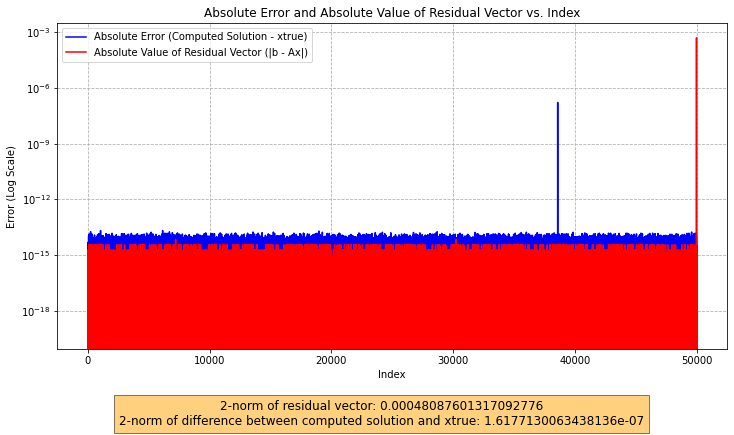

In [5]:
# load the data: u, v, x_true, b, d from their respective {vector}.txt files
u = np.loadtxt("data/u.txt")
v = np.loadtxt("data/v.txt")
x_true = np.loadtxt("data/xtrue.txt")
b = np.loadtxt("data/b.txt")
D = np.loadtxt("data/d.txt")

# Solve the associated linear system Ax = b for x.
x_comp = solve_lu_b(D, u, v, b)
# Using a logarithmic scale for the error, plot both the absolute error of the difference between your computed solution and xtrue and the absolute value of the residual vector r = b − Ax generated by your solution vs the index of the respective vector (i.e., the x-axis will range from 1 to 50,000).
absolute_error = np.abs(x_comp - x_true)

residual_vector = b - compute_Ax(D, u, v, x_comp)

# compute 2-norm of residual vector (precision) and 2-norm of difference between computed solution and xtrue (accuracy)
norm_residual_vector = np.linalg.norm(residual_vector, 2)
norm_difference = np.linalg.norm(x_comp - x_true, 2)
norm_x_true = np.linalg.norm(x_true, 2)
norm_b = np.linalg.norm(b, 2)

print(f"2-norm of residual vector: {norm_residual_vector}")
print(f"2-norm of difference between computed solution and xtrue: {norm_difference}")
print(f"2-norm of xtrue: {norm_x_true}")
print(f"2-norm of b: {norm_b}")

# absolute error norm / residual vector norm
print(f"Absolute Error Norm / Residual Vector Norm: {norm_difference / norm_residual_vector}")

# compute relative error
relative_error = norm_difference / norm_x_true
print(f"Relative error: {relative_error}")

# compute relative residual
relative_residual = norm_residual_vector / norm_b
print(f"Relative residual (input): {relative_residual}")

print(f"Relative Error / Relative Residual: {relative_error / relative_residual}")

plt.figure(figsize=(12, 6))
plt.semilogy(range(1, len(D) + 1), absolute_error, label='Absolute Error (Computed Solution - xtrue)', color='blue')
plt.semilogy(range(1, len(D) + 1), np.abs(residual_vector), label='Absolute Value of Residual Vector (|b - Ax|)', color='red')
plt.xlabel('Index')
plt.ylabel('Error (Log Scale)')
plt.figtext(0.5, -0.05, f"2-norm of residual vector: {norm_residual_vector:}\n2-norm of difference between computed solution and xtrue: {norm_difference:}", ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.title('Absolute Error and Absolute Value of Residual Vector vs. Index')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()